###Importing Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import math

### Loading Data

In [2]:
df = pd.read_csv('../data/Real estate.csv')

df = df.drop('No',axis = 1).dropna()

df = df.sample(frac=1)

df=(df-df.mean())/df.std()

X_ = df.drop('Y house price of unit area', axis = 1).to_numpy()
X = np.hstack((np.ones((len(X_),1)),X_))
y = df['Y house price of unit area'].to_numpy()

### Gradient Descent

In [3]:
def mse_cost(X,y,t):
    error = np.dot(X,t) - y
    cost = 1/(2*len(X)) * np.dot(error.T, error)
    return cost

def gradient_descent(X, y, X_test = None, y_test = None, a = 0.001, e = 20000, 
                     l1 = 0, l2 = 0):
    n = len(X[0])
    t=np.random.rand(n)
    mse_arr_train = []
    mse_arr_test = []
    cost = 0

    if X_test is None:
        X_test = X
        y_test = y

    for i in range(e):
        _t = np.zeros(n)
        y_pred = np.dot(X,t)
        error = y_pred - y

        mse_arr_test.append(mse_cost(X_test,y_test,t))
        mse_arr_train.append(mse_cost(X,y,t))

        t = t - (a/len(X)  * np.dot(X.T, error)) - l1*(np.array([1 if i>0 else -1 for i in t ])) - 2*l2*t

    return t,mse_arr_train,mse_arr_test,cost



### a) K Fold

In [4]:
def kfold(X,y,k):
    n = len(X)
    l = n//k

    a = []

    for i in range(k):
        a.append([(np.concatenate((X[0:i*l],X[i*l+l:]),axis = 0),
                   np.concatenate((y[0:i*l],y[i*l+l:]),axis = 0)),
                  (X[i*l:i*l+l],y[i*l:i*l+l])])

    return a

In [5]:
def kfold_gradient_descent(k, X=X, y=y, plot = False, l1=0, l2 = 0):
    kfoldsplit = kfold(X,y,k)
    rmse_test = 0
    rmse_train = 0
    for ki,((X_train,y_train),(X_test,y_test)) in enumerate(kfoldsplit):
        t,m_train,m_test,c= gradient_descent(X_train,y_train,X_test,y_test, l1=l1, l2=l2)
        # print(t)

        m_train = [math.sqrt(i) for i in m_train]
        m_test = [math.sqrt(i) for i in m_test]

        if plot:
            sns.lineplot(data = m_train,label = 'train')
            sns.lineplot(data = m_test,label = 'val')
            plt.xlabel('iterations')
            plt.ylabel('RMSE')
            plt.show()

        n = len(X_test[0])
        y_pred = np.dot(X_test,t)
        error = y_pred - y_test
        rmsecost = math.sqrt(mse_cost(X_test,y_test,t))
        rmse_test += rmsecost
        rmsecost = math.sqrt(mse_cost(X_train,y_train,t))
        rmse_train += rmsecost
    rmse_test /= k
    rmse_train /= k
    return rmse_train,rmse_test

for k in range(2,6):
    print(f'{kfold_gradient_descent(k,X,y)[1]}')

0.46664129079347116
0.45906016623874435
0.46024809773886427
0.45946124033416275


### b) plot rmse

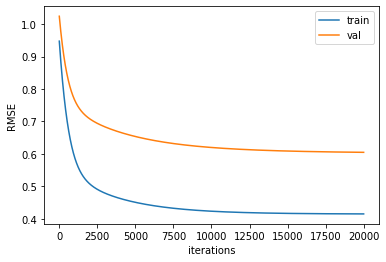

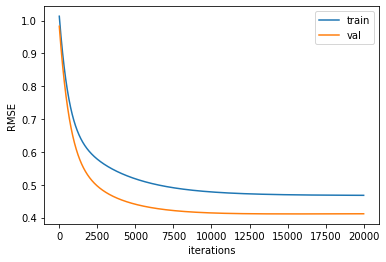

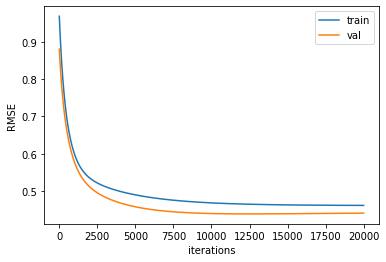

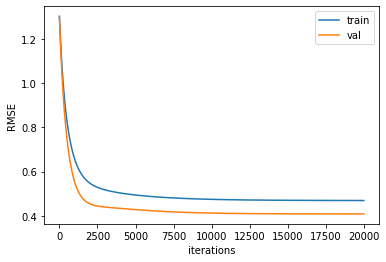

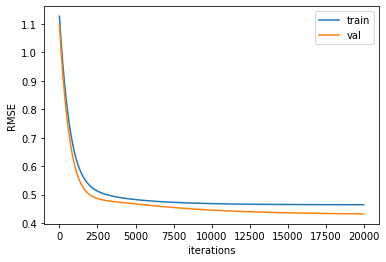

(0.4553466586738174, 0.45938358605651963)

In [6]:
kfold_gradient_descent(5,X,y,True)

### c) L1 and L2 regularization

0.9772442288481038
0.710078359257533
0.7026281972094401
0.7032746506971866
0.47424644613013844


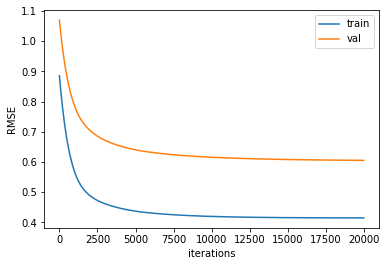

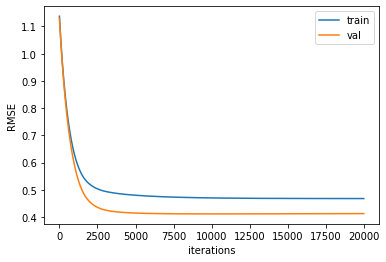

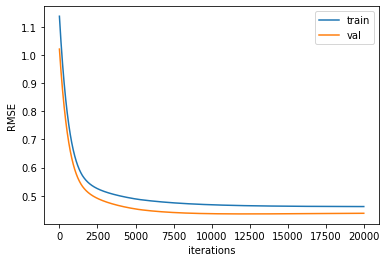

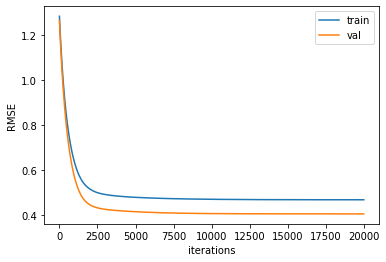

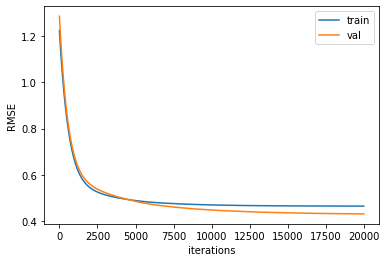

0.4583895070508593
0.4591162112419475


In [7]:
print(kfold_gradient_descent(5,l1 = 1)[1])
print(kfold_gradient_descent(5,l1 = 0.1)[1])
print(kfold_gradient_descent(5,l1 = 0.01)[1])
print(kfold_gradient_descent(5,l1 = 0.001)[1])
print(kfold_gradient_descent(5,l1 = 0.0001)[1])
print(kfold_gradient_descent(5,l1 = 0.00001, plot=True)[1])
print(kfold_gradient_descent(5,l1 = 0.000001)[1])

2.2741193608923756e+23
0.6991965036472604
0.6614489270725705
0.5226019333718006
0.4612491266950826


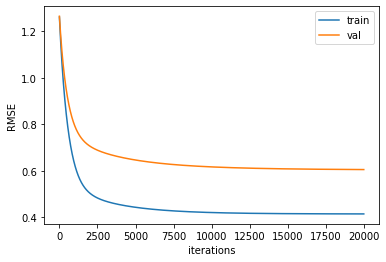

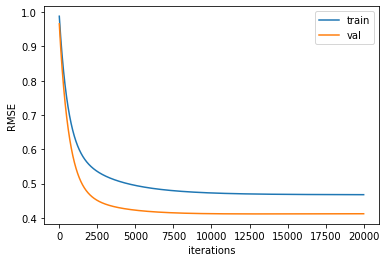

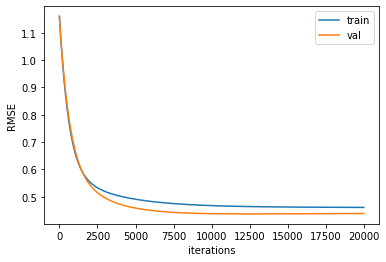

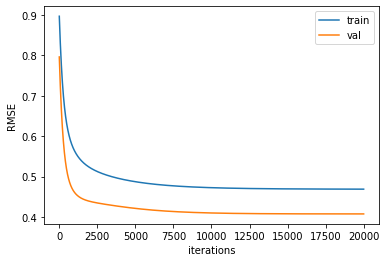

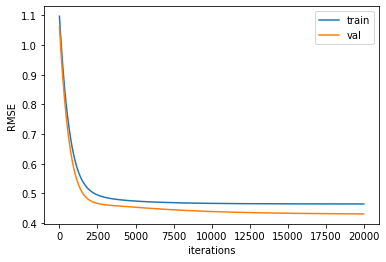

0.45903597260033263
0.4595140511511012


In [8]:
print(kfold_gradient_descent(5,l2 = 1)[1])
print(kfold_gradient_descent(5,l2 = 0.1)[1])
print(kfold_gradient_descent(5,l2 = 0.01)[1])
print(kfold_gradient_descent(5,l2 = 0.001)[1])
print(kfold_gradient_descent(5,l2 = 0.0001)[1])
print(kfold_gradient_descent(5,l2 = 0.00001,plot=True)[1])
print(kfold_gradient_descent(5,l2 = 0.000001)[1])

### Normal Equation

In [9]:
def normal_method(X, y):
    theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    return theta

def kfold_normal_method(k, X, y, plot = False, l1=0, l2 = 0):
    kfoldsplit = kfold(X,y,k)
    rmse_test = 0
    tt = []
    rmse_arr = []
    for ki,((X_train,y_train),(X_test,y_test)) in enumerate(kfoldsplit):
        theta = normal_method(X_train,y_train)
        
        y_pred = np.dot(X_test,theta)
        error = y_pred - y_test
        rmse = sum(np.square(error))
        rmse /= 2*len(X_test)
        rmse **= 0.5
        rmse_test += rmse
        tt.append(theta)
        rmse_arr.append(rmse)
    rmse_test /= k
    return rmse_test, tt, rmse_arr



rmse, tt, ra = kfold_normal_method(5,X,y)

print('Average RMSE: ', rmse)

for i in range(len(tt)):
    print()
    print('fold =',i+1)
    print('rmse =',ra[i])
    for j in range(len(tt[0])):
        print(f'θ({j})','=',tt[i][j])
    



Average RMSE:  0.4590736247710578

fold = 1
rmse = 0.6018957304124182
θ(0) = -0.0174183782932747
θ(1) = 0.09734809718362236
θ(2) = -0.18953081607302752
θ(3) = -0.3767362377631027
θ(4) = 0.24864541484730218
θ(5) = 0.2063613487502134
θ(6) = 0.023423734885002157

fold = 2
rmse = 0.4126298300159082
θ(0) = 0.023246689884062942
θ(1) = 0.10134446355915541
θ(2) = -0.21716725644509477
θ(3) = -0.4368615945603058
θ(4) = 0.22372542977805476
θ(5) = 0.2043970433940736
θ(6) = -0.019227557485118174

fold = 3
rmse = 0.4435311611278766
θ(0) = 0.02237475753379666
θ(1) = 0.1346233498313899
θ(2) = -0.2285538341120172
θ(3) = -0.45793736894608106
θ(4) = 0.2542860870742524
θ(5) = 0.18821464377245523
θ(6) = -0.04509501700668128

fold = 4
rmse = 0.40838460315855635
θ(0) = -0.02535853331411203
θ(1) = 0.10166664097021741
θ(2) = -0.24687273949025806
θ(3) = -0.42300135685923523
θ(4) = 0.2587535910369977
θ(5) = 0.18642453736304265
θ(6) = -0.028136945204104036

fold = 5
rmse = 0.4289267991405297
θ(0) = -0.00781228037